## Run INSPIRE on STARmap PLUS slices from mouse hippocampus

In this tutorial, we show INSPIRE’s ability to perform spatial registration between 2D slices.

The STARmap PLUS slices are publicly available at https://doi.org/10.5281/zenodo.7458952.

### Import packages

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import umap
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.cm import get_cmap
from matplotlib.lines import Line2D

import INSPIRE

import warnings
warnings.filterwarnings("ignore")

### Load data

In [2]:
data_dir = "/gpfs/gibbs/pi/zhao/jz874/jiazhao/reference-free_spatial-integration/backup_project_folders/reference-free_spatial-integration/reference-free_integration_3d-alignment_v2/STARmapPLUS"
adata_1 = sc.read_h5ad(data_dir + "/adata_8m_disease_rep1.h5ad")
adata_1.var_names_make_unique()
adata_2 = sc.read_h5ad(data_dir + "/adata_8m_disease_rep2.h5ad")
adata_2.var_names_make_unique()

In [3]:
theta = 0.5
R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
adata_1.obsm["spatial"] = adata_1.obsm["spatial"] @ R.T + np.array([5000,5000]).reshape((1,-1))

In [4]:
adata_st_list = [adata_2, adata_1]

### Data preprocessing

Finding highly variable genes...
shape of adata 0 before quality control:  (8202, 2766)
shape of adata 0 after quality control:  (8202, 2766)
shape of adata 1 before quality control:  (8186, 2766)
shape of adata 1 after quality control:  (8186, 2766)
Find 2382 shared highly variable genes among datasets.
Concatenate datasets as a full anndata for better visualization...


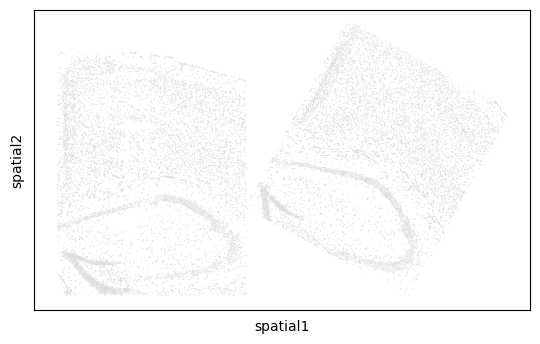

Store counts and library sizes for Poisson modeling...
Normalize data...


In [5]:
adata_st_list, adata_full = INSPIRE.utils.preprocess(adata_st_list=adata_st_list,
                                                     num_hvgs=2500,
                                                     min_genes_qc=1,
                                                     min_cells_qc=1,
                                                     spot_size=100,
                                                     limit_num_genes=False)

### Build spatial graph

In [6]:
adata_st_list = INSPIRE.utils.build_graph_LGCN(adata_st_list=adata_st_list, 
                                               rad_cutoff_list=[300,300],
                                               k_lgcn=5)

Start building graphs...
Build graphs and prepare node features for LGCN networks
Radius for graph connection is 300.0000.
7.5111 neighbors per cell on average.
Node features for slice 0 : (8202, 14292)
Radius for graph connection is 300.0000.
7.6316 neighbors per cell on average.
Node features for slice 1 : (8186, 14292)


### Run INSPIRE model

In [7]:
model = INSPIRE.model.Model_LGCN(adata_st_list=adata_st_list,
                                 n_spatial_factors=15,
                                 n_training_steps=10000,
                                 batch_size=1024,
                                 different_platforms=True
                                )

In [8]:
model.train(adata_st_list)

  0%|          | 2/10000 [00:00<43:26,  3.84it/s]  

Step: 0, d_loss: 1.4104, Loss: 1235.0050, recon_loss: 940.8315, fe_loss: 81.3106, geom_loss: 206.5332, beta_loss: 207.9480, gan_loss: 0.7842


  5%|▌         | 502/10000 [01:29<28:06,  5.63it/s]

Step: 500, d_loss: 1.3129, Loss: 1163.2123, recon_loss: 882.8410, fe_loss: 72.9644, geom_loss: 89.6926, beta_loss: 204.8077, gan_loss: 0.8055


 10%|█         | 1002/10000 [02:58<26:59,  5.56it/s]

Step: 1000, d_loss: 1.2439, Loss: 1126.2609, recon_loss: 845.2407, fe_loss: 72.3116, geom_loss: 92.1219, beta_loss: 205.9632, gan_loss: 0.9029


 15%|█▌        | 1502/10000 [04:26<25:12,  5.62it/s]

Step: 1500, d_loss: 1.1951, Loss: 1076.0878, recon_loss: 795.7443, fe_loss: 71.8930, geom_loss: 81.4161, beta_loss: 205.8059, gan_loss: 1.0163


 20%|██        | 2002/10000 [05:55<23:40,  5.63it/s]

Step: 2000, d_loss: 1.1884, Loss: 1045.0409, recon_loss: 765.5323, fe_loss: 71.2960, geom_loss: 72.5290, beta_loss: 205.7174, gan_loss: 1.0446


 25%|██▌       | 2502/10000 [07:24<22:16,  5.61it/s]

Step: 2500, d_loss: 1.0871, Loss: 1035.4886, recon_loss: 756.3441, fe_loss: 71.4071, geom_loss: 69.1286, beta_loss: 205.2186, gan_loss: 1.1364


 30%|███       | 3002/10000 [08:53<20:59,  5.56it/s]

Step: 3000, d_loss: 1.0116, Loss: 1014.4407, recon_loss: 735.9926, fe_loss: 70.8247, geom_loss: 62.7238, beta_loss: 205.1502, gan_loss: 1.2188


 35%|███▌      | 3502/10000 [10:21<19:15,  5.63it/s]

Step: 3500, d_loss: 0.9507, Loss: 1002.5665, recon_loss: 724.9562, fe_loss: 70.6000, geom_loss: 58.6116, beta_loss: 204.6067, gan_loss: 1.2314


 40%|████      | 4002/10000 [11:49<17:58,  5.56it/s]

Step: 4000, d_loss: 0.9047, Loss: 1008.9993, recon_loss: 731.2941, fe_loss: 70.7194, geom_loss: 55.3620, beta_loss: 204.7021, gan_loss: 1.1765


 45%|████▌     | 4502/10000 [13:18<16:16,  5.63it/s]

Step: 4500, d_loss: 0.8874, Loss: 1008.4149, recon_loss: 730.9824, fe_loss: 70.7026, geom_loss: 54.3259, beta_loss: 204.4097, gan_loss: 1.2336


 50%|█████     | 5002/10000 [14:47<14:51,  5.61it/s]

Step: 5000, d_loss: 0.8766, Loss: 1003.8329, recon_loss: 726.6323, fe_loss: 70.5739, geom_loss: 53.7481, beta_loss: 204.3933, gan_loss: 1.1583


 55%|█████▌    | 5502/10000 [16:15<13:30,  5.55it/s]

Step: 5500, d_loss: 0.8707, Loss: 992.8505, recon_loss: 715.6853, fe_loss: 70.3451, geom_loss: 51.6561, beta_loss: 204.4697, gan_loss: 1.3171


 60%|██████    | 6002/10000 [17:44<12:00,  5.55it/s]

Step: 6000, d_loss: 0.8760, Loss: 996.8654, recon_loss: 719.5827, fe_loss: 70.3448, geom_loss: 50.0077, beta_loss: 204.5616, gan_loss: 1.3762


 65%|██████▌   | 6502/10000 [19:13<10:30,  5.54it/s]

Step: 6500, d_loss: 0.9300, Loss: 985.0158, recon_loss: 708.3918, fe_loss: 69.8538, geom_loss: 50.6949, beta_loss: 204.2123, gan_loss: 1.5439


 70%|███████   | 7002/10000 [20:42<08:59,  5.55it/s]

Step: 7000, d_loss: 0.8161, Loss: 977.7006, recon_loss: 701.2789, fe_loss: 69.6130, geom_loss: 48.8191, beta_loss: 204.2167, gan_loss: 1.6157


 75%|███████▌  | 7502/10000 [22:11<07:24,  5.62it/s]

Step: 7500, d_loss: 0.8450, Loss: 985.0463, recon_loss: 708.2975, fe_loss: 69.8068, geom_loss: 48.9086, beta_loss: 204.5784, gan_loss: 1.3854


 80%|████████  | 8002/10000 [23:40<05:56,  5.61it/s]

Step: 8000, d_loss: 0.8089, Loss: 988.6876, recon_loss: 712.1122, fe_loss: 69.8727, geom_loss: 48.1256, beta_loss: 204.2519, gan_loss: 1.4884


 85%|████████▌ | 8502/10000 [25:09<04:30,  5.55it/s]

Step: 8500, d_loss: 0.8545, Loss: 987.7185, recon_loss: 710.9441, fe_loss: 69.9291, geom_loss: 47.3902, beta_loss: 204.2786, gan_loss: 1.6189


 90%|█████████ | 9002/10000 [26:38<02:59,  5.56it/s]

Step: 9000, d_loss: 0.8458, Loss: 990.4579, recon_loss: 713.8364, fe_loss: 69.9384, geom_loss: 47.3073, beta_loss: 204.2672, gan_loss: 1.4697


 95%|█████████▌| 9502/10000 [28:07<01:28,  5.63it/s]

Step: 9500, d_loss: 0.9550, Loss: 983.6428, recon_loss: 707.0034, fe_loss: 69.7591, geom_loss: 47.7403, beta_loss: 204.3299, gan_loss: 1.5956


100%|██████████| 10000/10000 [29:35<00:00,  5.63it/s]


### Access spot representations, proportions of spatial factors in spots, and gene loading matrix

In [9]:
adata_full, basis_df = model.eval(adata_st_list, adata_full)
basis = np.array(basis_df.values)

Add cell/spot proportions of spatial factors into adata_full.obs...
Add cell/spot latent representations into adata_full.obsm['latent']...


Gene loading matrix is saved as basis.

### Spatial distributions of spatial factors in tissues

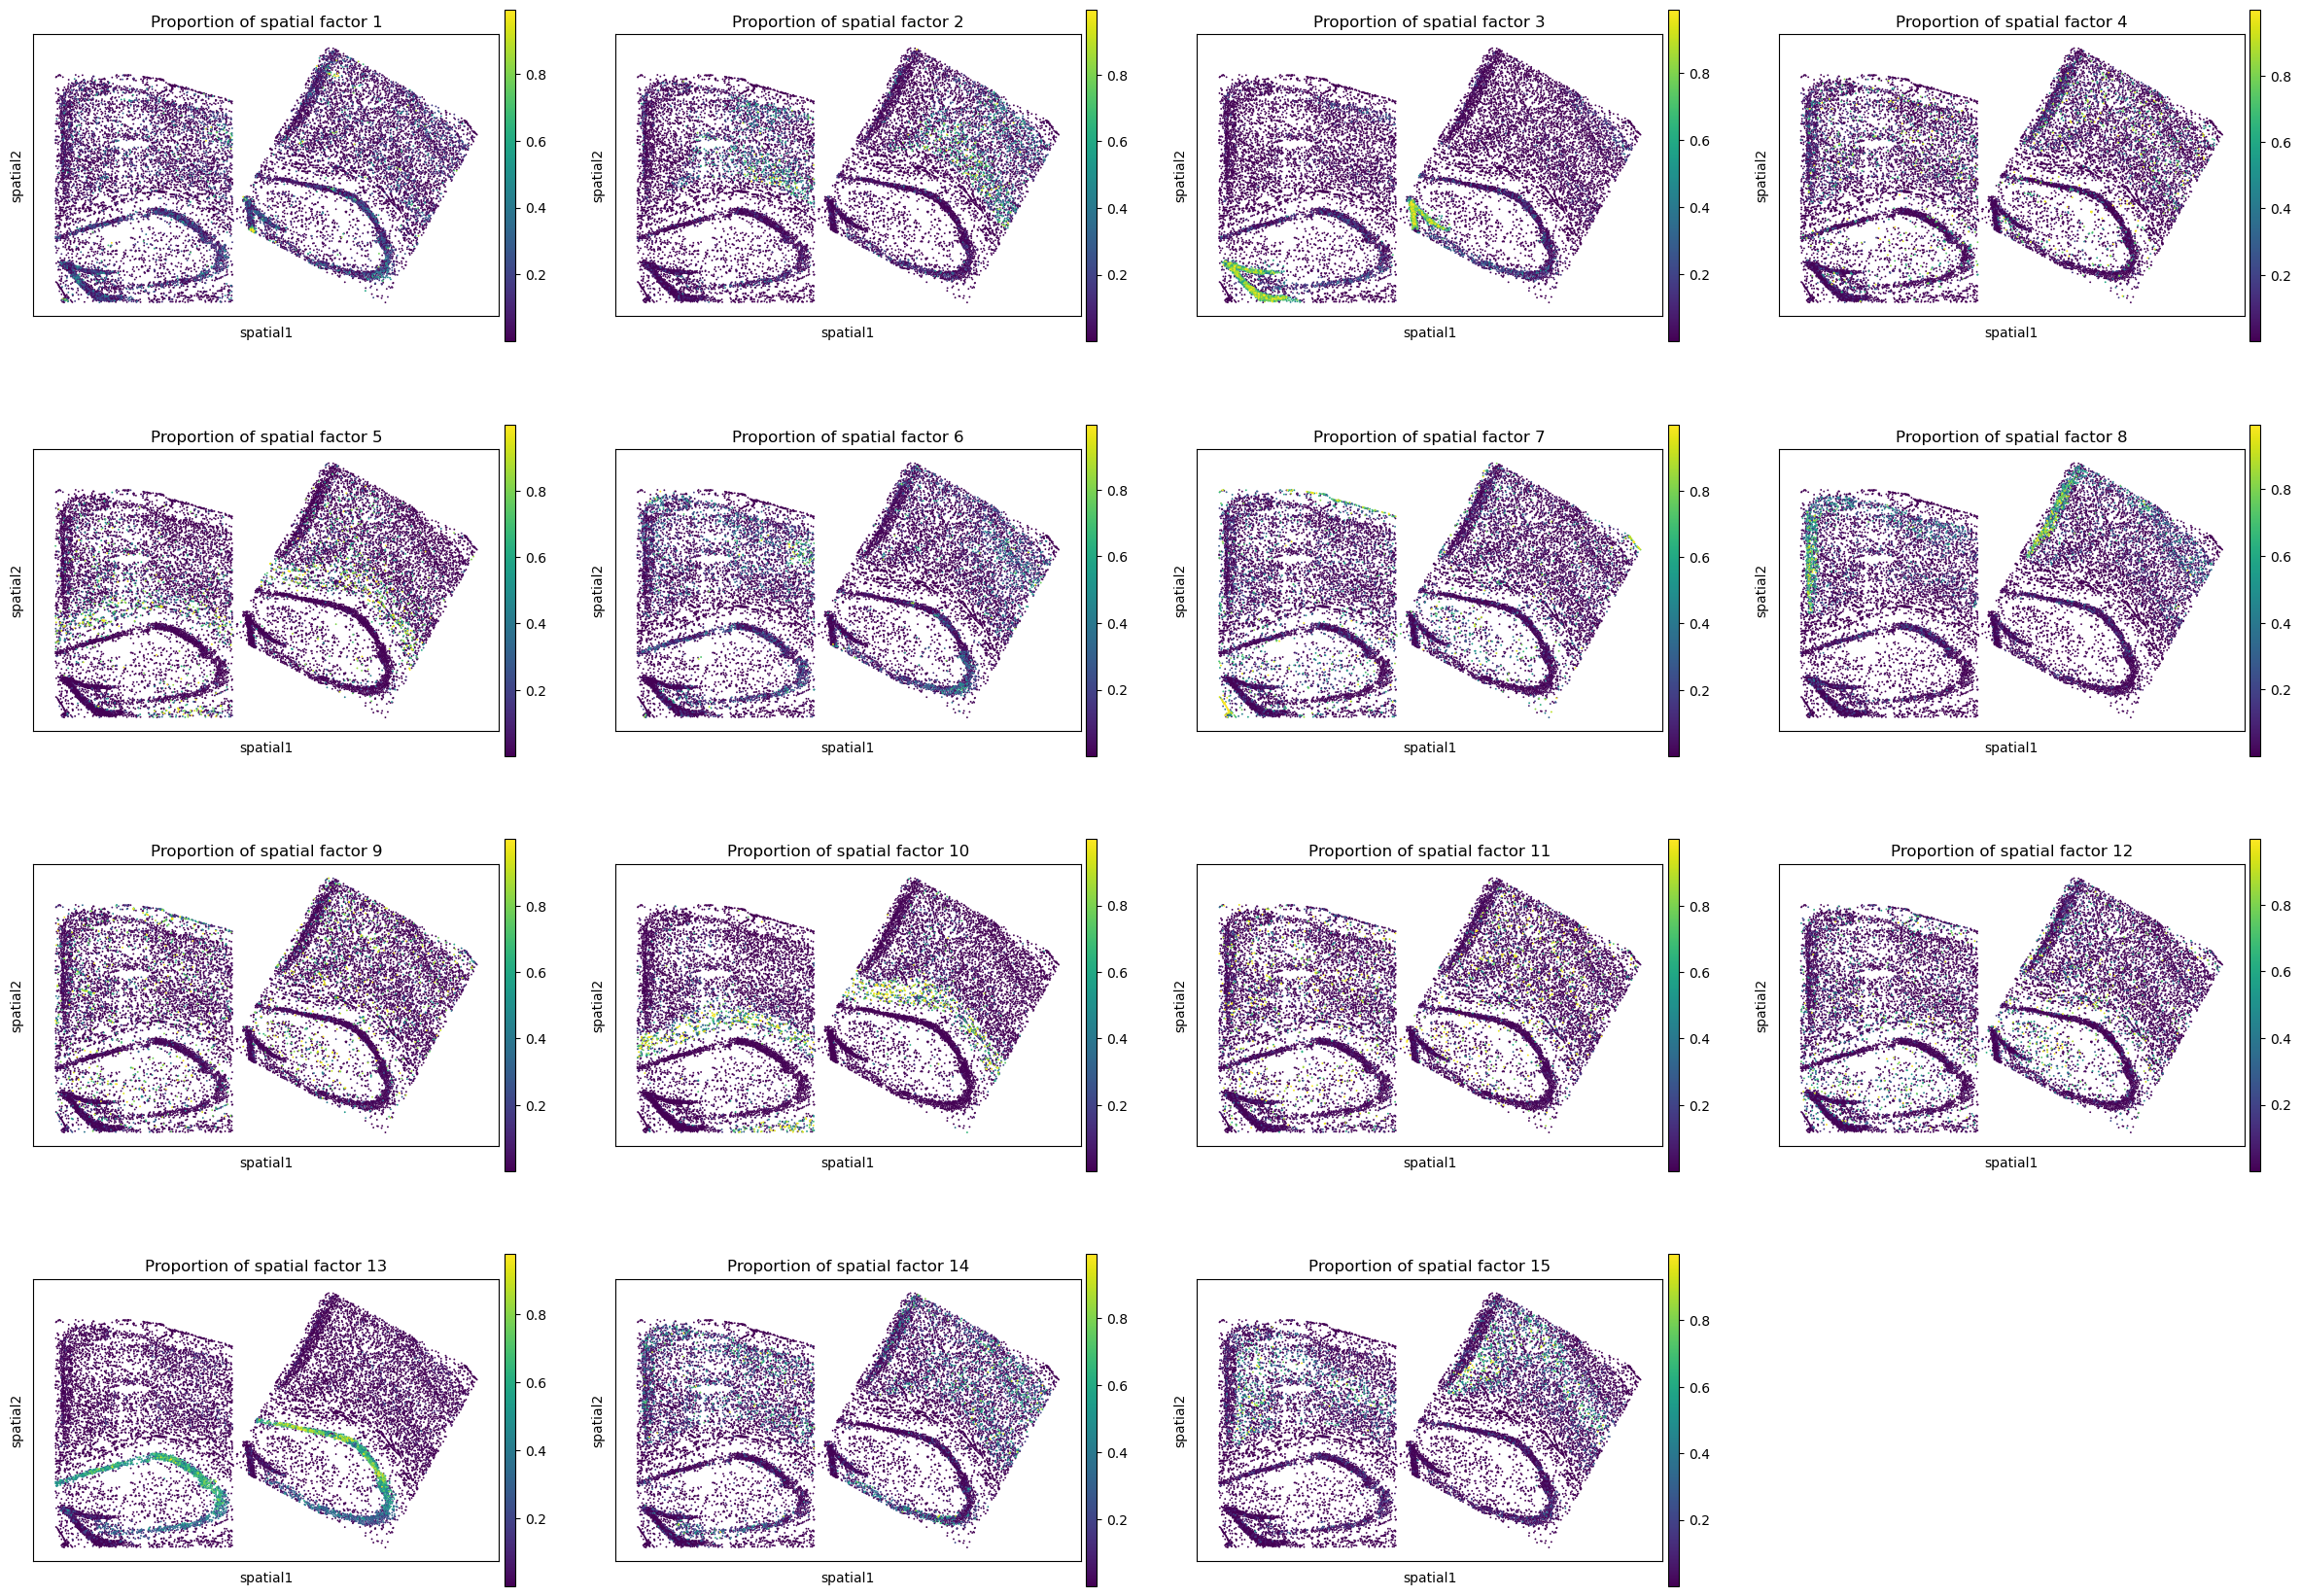

In [10]:
sc.pl.spatial(adata_full, color=["Proportion of spatial factor "+str(i+1) for i in range(15)], spot_size=200.)

### Spot representations

In [11]:
# calculate 2D UMAP coordinate of spots based on INSPIRE's learned cell representations.
reducer = umap.UMAP(n_neighbors=30,
                    n_components=2,
                    metric="correlation",
                    n_epochs=None,
                    learning_rate=1.0,
                    min_dist=0.3,
                    spread=1.0,
                    set_op_mix_ratio=1.0,
                    local_connectivity=1,
                    repulsion_strength=1,
                    negative_sample_rate=5,
                    a=None,
                    b=None,
                    random_state=1234,
                    metric_kwds=None,
                    angular_rp_forest=False,
                    verbose=True)
embedding = reducer.fit_transform(adata_full.obsm['latent'])
adata_full.obsm["X_umap"] = embedding
adata_full.obs["label"] = adata_full.obs["label"].values.astype(str)

UMAP(angular_rp_forest=True, local_connectivity=1, metric='correlation', min_dist=0.3, n_neighbors=30, random_state=1234, repulsion_strength=1, verbose=True)
Sat Aug 24 12:50:49 2024 Construct fuzzy simplicial set
Sat Aug 24 12:50:49 2024 Finding Nearest Neighbors
Sat Aug 24 12:50:49 2024 Building RP forest with 11 trees
Sat Aug 24 12:50:51 2024 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	 5  /  14
	Stopping threshold met -- exiting after 5 iterations
Sat Aug 24 12:51:00 2024 Finished Nearest Neighbor Search
Sat Aug 24 12:51:02 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Aug 24 12:51:17 2024 Finished embedding


In [12]:
# perform clustering on INSPIRE’s learned cell representations to identify spatial domains across slices.
sc.pp.neighbors(adata_full, use_rep="latent", n_neighbors=30)
sc.tl.louvain(adata_full, resolution=1.5)

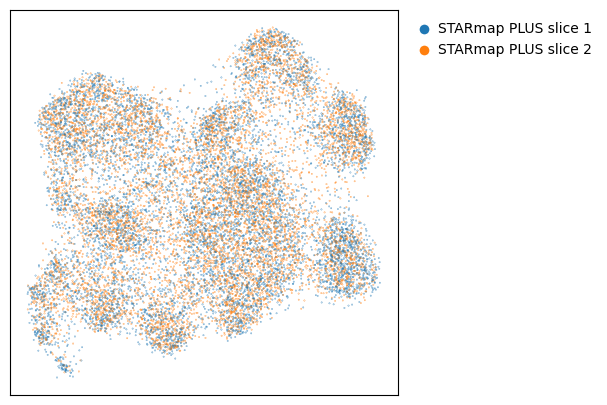

In [13]:
adata = adata_full

size = 0.05
umap = adata.obsm["X_umap"]
n_cells = umap.shape[0]
np.random.seed(1234)
order = np.arange(n_cells)
np.random.shuffle(order)

adata.obs["slice_color"] = ""
adata.obs["slice_color"][adata.obs["slice"].values.astype(str) == str(0)] = "tab:blue"
adata.obs["slice_color"][adata.obs["slice"].values.astype(str) == str(1)] = "tab:orange"

f = plt.figure(figsize=(5,5))

ax3 = f.add_subplot(1,1,1)
scatter2 = ax3.scatter(umap[order, 0], umap[order, 1], s=size, c=adata.obs["slice_color"][order], rasterized=True, marker='o')
ax3.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)

legend_elements_slice = [Line2D([0], [0], marker='o', color="w", label='STARmap PLUS slice 1', markerfacecolor="tab:blue", markersize=10),
                         Line2D([0], [0], marker='o', color="w", label='STARmap PLUS slice 2', markerfacecolor="tab:orange", markersize=10)]
ax3.legend(handles=legend_elements_slice, loc="upper left", bbox_to_anchor=(1, 1.), frameon=False,
           markerscale=.8, fontsize=10, handletextpad=0., ncol=1)

f.subplots_adjust(hspace=0.02, wspace=0.1)
plt.show()

In [14]:
rgb_10 = [i for i in get_cmap('Set3').colors]
rgb_20 = [i for i in get_cmap('tab20').colors]
rgb_20b = [i for i in get_cmap('tab20b').colors]
rgb_dark2 = [i for i in get_cmap('Dark2').colors]
rgb_pst1 = [i for i in get_cmap('Pastel1').colors]
rgb_acc = [i for i in get_cmap('Accent').colors]
rgb2hex_10 = [mpl.colors.rgb2hex(color) for color in rgb_10]
rgb2hex_20 = [mpl.colors.rgb2hex(color) for color in rgb_20]
rgb2hex_20b = [mpl.colors.rgb2hex(color) for color in rgb_20b]
rgb2hex_20b_new = [rgb2hex_20b[i] for i in [0, 3, 4, 7, 8, 11, 12, 15, 16, 19]]
rgb2hex_dark2 = [mpl.colors.rgb2hex(color) for color in rgb_dark2]
rgb2hex_pst1 = [mpl.colors.rgb2hex(color) for color in rgb_pst1]
rgb2hex_acc = [mpl.colors.rgb2hex(color) for color in rgb_acc]
rgb2hex = rgb2hex_20 + rgb2hex_20b_new + rgb2hex_dark2 + rgb2hex_pst1 + rgb2hex_acc

adata.obs["c_hex"] = ""
for i in range(len(set(adata.obs["louvain"]))):
    adata.obs["c_hex"][adata.obs["louvain"].values.astype(str) == str(i)] = rgb2hex[i]

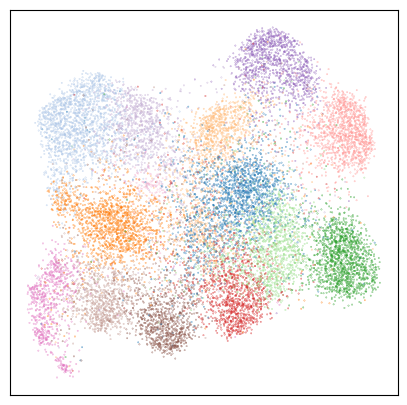

In [15]:
f = plt.figure(figsize=(5,5))
ax1 = f.add_subplot(1,1,1)
scatter1 = ax1.scatter(umap[order, 0], umap[order, 1], s=size, c=adata.obs["c_hex"][order], rasterized=True)
ax1.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)
plt.show()

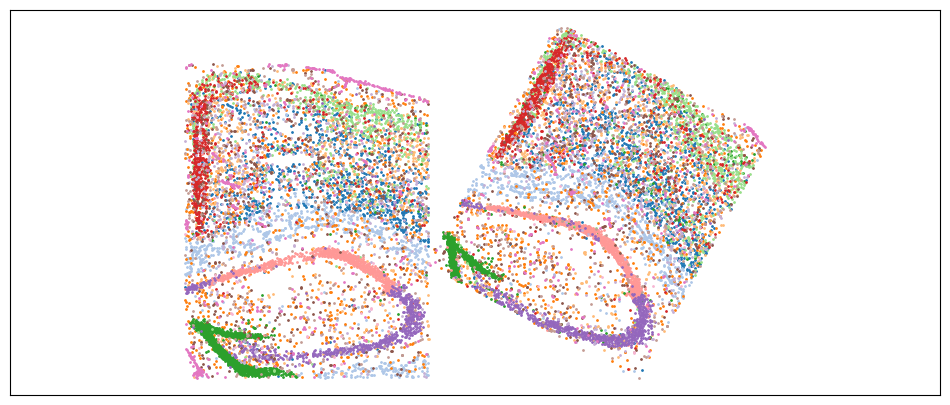

In [16]:
size = 1

# louvain
f = plt.figure(figsize=(12,5))
ax = f.add_subplot(1,1,1)
ax.axis('equal')
colors = rgb2hex
for i in range(len(set(adata.obs["louvain"]))):
    ax.scatter(adata.obsm["spatial"][adata.obs["louvain"].values.astype(str)==str(i), 0], 
               -adata.obsm["spatial"][adata.obs["louvain"].values.astype(str)==str(i), 1], 
               s=size, c=colors[i], label="cluster "+str(i), rasterized=True)
ax.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)
plt.show()

### Save results

In [17]:
res_path = "Results/INSPIRE_registration_starmapplus"
adata_full.write(res_path + "/adata_inspire.h5ad")
basis_df.to_csv(res_path + "/basis_df_inspire.csv")